In [38]:
import tensorflow as tf
import keras
import numpy as np
!pip install livelossplot --quiet # library to plot training logs
from livelossplot import PlotLossesKeras
"Keras", keras.__version__, "tf", tf.__version__

('Keras', '2.1.6', 'tf', '1.9.0')

In [39]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

## loading in data

In [0]:
(x_train, y_train),(x_test, y_test) = keras.datasets.cifar10.load_data()

#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

doing a simple normalization of the data. since these are images, its pretty straightforward to use data augmentation too, but this is just a simple excercise to compare the effects of dropout so no need.

In [0]:
def normalize(x):
  """takes in an array x and returns a normalized version"""
  min_val = np.min(x)
  max_val = np.max(x)
  x = (x-min_val) / (max_val-min_val)

In [5]:
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

## training with no dropout

first up, training a simple CNN model without dropout:

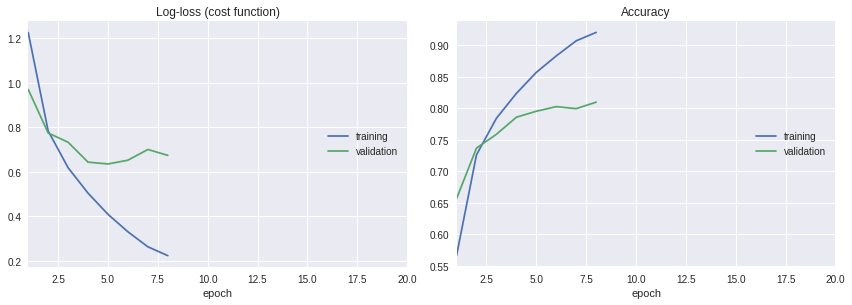

10000/10000 [==============================] - 4s 393us/step


[0.6742508942127228, 0.8096]

In [43]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', 
                 input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512, activation='relu'))

model.add(Dense(10, activation='softmax'))

model.compile(optimizer='Adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=20, 
          validation_data=(x_test, y_test), 
          callbacks=[PlotLossesKeras(), EarlyStopping(patience=3)])

model.evaluate(x_test, y_test)

this starts overfitting pretty quickly, though we did get ~80% accuracy at 5 epochs, which isn't bad for a quick and dirty CNN. 

The graph shows why its a good idea to use: `EarlyStopping` to callbacks to stop wasting time over training the NN.

now lets try the same model with dropout:

## same NN with dropout added

I've used `0.2` as the convulutional layer dropout and `0.2` for the dense layer, though the literature suggests the dense layer dropout should be higher.

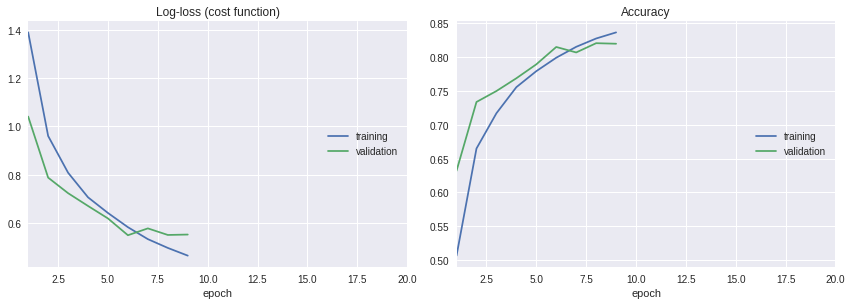

10000/10000 [==============================] - 4s 373us/step


[0.5518479048728943, 0.8199]

In [44]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', 
                 input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

model.compile(optimizer='Adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=20, 
          validation_data=(x_test, y_test), 
          callbacks=[PlotLossesKeras(), EarlyStopping(patience=3)])

model.evaluate(x_test, y_test)

what beautiful graphs! especially compared to the version without dropout.

its quite clear from the losses and accuracy that adding dropout has an  important impact on the NN. in particular:

- with dropout, the model starts at a lower accuracy, but thats expected as there is less information passing through
- its no longer overfitting, so can train longer and get better results. I stopped it early but it can be tweaked to train longer.
- accuracy has increased, though not by much. 
- our simple model still starts overfitting, though later than before.

So dropout is a clear winner here, though of course it depends on the problem. there are a number of papers exploring effects of dropout on differrent problems. 
